In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [8]:
def sample_abs_std_normal(N):
    res = []

    f = lambda x : 2 / np.sqrt(2*np.pi) * np.exp(-x**2/2) * int(x>0)
    g = lambda x : np.exp(-x) * int(x>0)
    inv_cdf_g = lambda x : -np.log(1-x) * int(x>0 and x<1)
    c = np.sqrt(2 * np.e / np.pi)

    for _ in range(N):
        while True:
            U = np.random.rand()

            U_ = np.random.rand()
            Y = inv_cdf_g(U_)

            if U < f(Y) / (c * g(Y)):
                break
        res.append(Y)
    
    return res

# def sample_abs_std_normal(N):
#     res = []
#     f = lambda x : (2/np.sqrt(2*math.pi))*math.exp(-x**2/2) * int(x > 0)
#     c = np.sqrt(2*math.exp(1)/math.pi)
#     g = lambda x : math.exp(-x) * int(x > 0)
#     inv_g = lambda u : -math.log(1-u) * int(u > 0 and u < 1)
#     for _ in range(N):
#         while True:
#             U = np.random.rand()
#             x = inv_g(np.random.rand())
#             if c*U*g(x) <= f(x):
#                 break
#         res.append(x)
#     return res

def sample_std_normal(N):
    return [np.random.choice([-1,1]) * _ for _ in sample_abs_std_normal(N)]

def sample_normal(N, mu, sigma):
    return [(_ * sigma) + mu for _ in sample_std_normal(N)]

# Exercise 4

## Question 3

In [32]:
g = lambda x : 2 * x**2 * np.sqrt(2*np.pi) * int(x >= 9/2)

In [33]:
m0 = 0
sigma = 2
N = 10**4

X = sample_normal(N, m0, sigma)

In [34]:
est_of_I = sum([g(x_) for x_ in X])/len(X)
est_of_I

1.7535750870774183

## Question 4

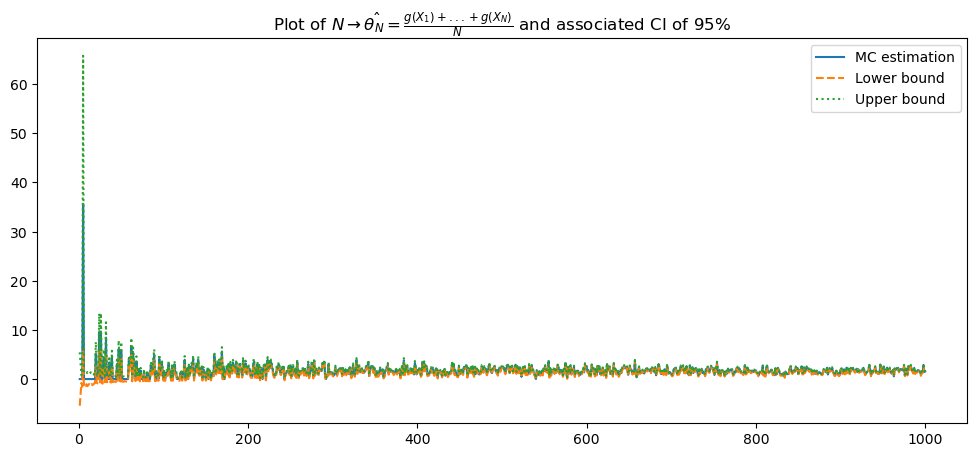

In [36]:
N = 1000
alpha = 0.05

est = []
inf = []
sup = []

for N_ in range(1, N+1):
    X = sample_normal(N_, m0, sigma)
    theta_hat = sum([g(x_) for x_ in X])/N_
    std = np.sqrt(sum([(x_ - theta_hat)**2 for x_ in X])/(N_)) 
    est.append(theta_hat)
    inf.append(theta_hat - (norm.ppf(1-alpha/2) * std) / np.sqrt(N_))
    sup.append(theta_hat + (norm.ppf(1-alpha/2) * std) / np.sqrt(N_))


plt.figure(figsize=(12,5))

plt.plot([i for i in range(1,N+1)], est, label='MC estimation')
plt.plot([i for i in range(1,N+1)], inf, label='Lower bound', linestyle='--')
plt.plot([i for i in range(1,N+1)], sup, label='Upper bound', linestyle=':')

plt.title(r'Plot of $N \rightarrow \hat{\theta_{N}} = \frac{g(X_{1}) + ... + g(X_{N})}{N}$ and associated CI of 95%')
plt.legend()
plt.show()

## Question 5

In [40]:
#5.c

A = [0, 8]
N = 10**4
psi = sample_std_normal(N)

In [41]:
K = lambda mu,psi : g(mu + sigma*psi)**2 * np.exp(-((mu + sigma*psi - m0)**2 - sigma**2 * psi**2)/sigma**2)

def K_tilde(mu):
    return sum([K(mu, psi_) for psi_ in psi])/len(psi)

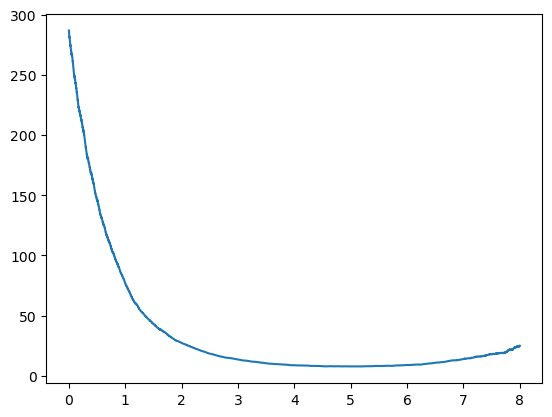

In [42]:
mu_vals = list(np.linspace(A[0], A[1], N))
k_tilde_vals = [K_tilde(mu_) for mu_ in mu_vals]
plt.plot(mu_vals, k_tilde_vals)

In [51]:
#5.d

# in slide psi is x, psi is a value not list
def get_l(mu, psi):
    return np.exp(-((mu + sigma*psi - m0)**2 - sigma**2 * psi**2)/sigma**2)

def get_g(mu, psi):
    return g(mu + sigma*psi)

# so K = g^2(mu)*l(mu)

#derive g with respect to x where g = lambda x : 2 * x**2 * np.sqrt(2*np.pi) * int(x >= 9/2)
g_prime = lambda x : 4 * x * np.sqrt(2*np.pi) * int(x >= 9/2)
l_prime = lambda x,psi : (-(2*x + 2*sigma*psi)/sigma**2)*get_l(x, psi)

# First derivative of K_tilde with respect to mu
def first_dev(mu, psi_samples):
    return np.mean([2 * get_l(mu, psi) * get_g(mu, psi) * (g_prime(psi) + get_g(mu, psi) * (-(mu+sigma*psi)/sigma**2)) for psi in psi_samples])

# Second derivative of K_tilde with respect to mu
def second_dev(mu, psi_samples):
    return np.mean([(2 * g_prime(mu) + 2 * get_g(mu, psi) * l_prime(mu, psi)) * (g_prime(mu) + get_g(mu, psi) * ((-mu-sigma*psi)/sigma**2)) + (get_g(mu, psi) * get_l(mu, psi) * (8*np.pi - 6*mu**2*np.sqrt(2*np.pi)/sigma**2 - sigma*psi*get_g(mu, psi)/sigma**2)) for psi in psi_samples])

# Newton-Raphson method
def newton_raphson(psi_samples, tol=1e-6, max_iter=100):
    mu = 0
    for _ in range(max_iter):
        mu_new = mu - first_dev(mu, psi_samples) / second_dev(mu, psi_samples)
        if abs(mu_new - mu) < tol:
            return mu_new
        mu = mu_new
    if mu < 0: 
        return 0
    elif mu > 8:
        return 8
    return mu

# def first_dev(mu, psi):
#     return (2*get_l(mu,psi)*get_g(mu,psi)) * (g_prime(psi) + get_g(mu,psi) * (-(mu+sigma*psi)/sigma**2))

# def second_dev(mu, psi):
#     return (2*g_prime(mu) + 2*get_g(mu, psi)*l_prime(mu, psi))*(g_prime(mu) + get_g(mu, psi)*((-mu-sigma*psi)/sigma**2)) + (get_g(mu, psi)*get_l(mu, psi)*(8*np.pi - 6*mu**2*np.sqrt(2*np.pi)/sigma**2 - sigma*psi*get_g(mu, psi)/sigma**2))

In [53]:
mu_opt = newton_raphson(psi)
mu_opt

4.844238779090245

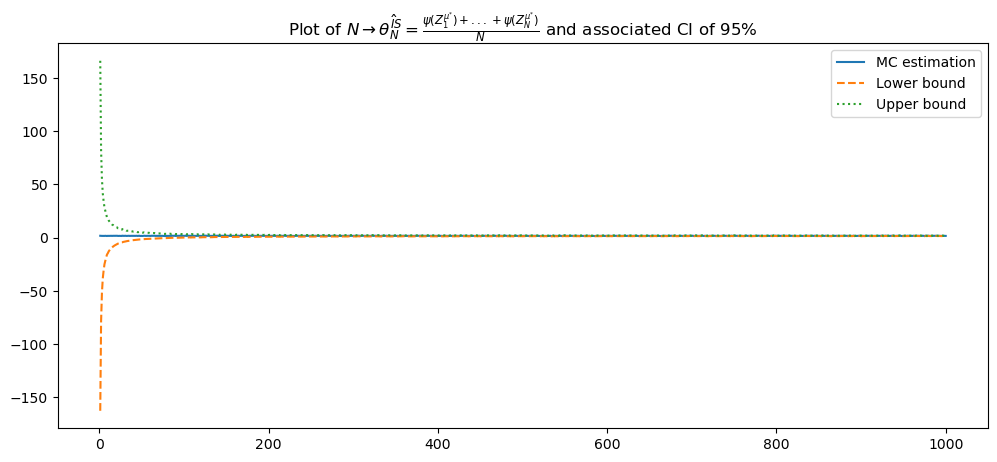

In [60]:
#e. 

N = 1000
alpha = 0.05

est = []
inf = []
sup = []

# si_carrée = K so np.sqrt(K)

for N_ in range(1, N+1):
    psi = sample_std_normal(N)
    theta_hat = sum([np.sqrt(K(mu_opt, psi_)) for psi_ in psi])/len(psi)
    std = np.sqrt(sum([(x_ - theta_hat)**2 for x_ in X])/(N_)) 
    est.append(theta_hat)
    inf.append(theta_hat - (norm.ppf(1-alpha/2) * std) / np.sqrt(N_))
    sup.append(theta_hat + (norm.ppf(1-alpha/2) * std) / np.sqrt(N_))


plt.figure(figsize=(12,5))

plt.plot([i for i in range(1,N+1)], est, label='MC estimation')
plt.plot([i for i in range(1,N+1)], inf, label='Lower bound', linestyle='--')
plt.plot([i for i in range(1,N+1)], sup, label='Upper bound', linestyle=':')

plt.title(r'Plot of $N \rightarrow \hat{\theta_{N}^{IS}} = \frac{\psi(Z_{1}^{\mu^{*}}) + ... + \psi(Z_{N}^{\mu^{*}})}{N}$ and associated CI of 95%')
plt.legend()
plt.show()